基于Incepiton的迁移学习，用 tf、keras、tfhub 实现

参照 [官网tutorials](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub#download_the_headless_model)

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
from tqdm.auto import tqdm
import concurrent.futures
from multiprocessing import Pool
import copy,os,sys,psutil
from collections import Counter,deque
import itertools
import os

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
root_path = "/home/zhoutong/notebook_collection/data/cv/tmp/Image_samples"
cg_path = root_path+"/cg_background"
landscape = root_path+"/landscape"
taj = root_path + "/Taj_Mahal"
qutb = root_path + "/Qutb_Minar"
IMAGE_SHAPE = (224,224)

In [4]:
sess_conf = tf.ConfigProto()
sess_conf.gpu_options.allow_growth = True  # 允许GPU渐进占用
sess_conf.allow_soft_placement = True  # 把不适合GPU的放到CPU上跑

g_graph = tf.Graph()
g_sess = tf.Session(graph=g_graph, config=sess_conf)

# 正式流程

In [ ]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(root_path, classes=['Taj_Mahal','Qutb_Minar'], target_size=IMAGE_SHAPE)
for image_batch, label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

# 重新加载一下iter
image_data = image_generator.flow_from_directory(root_path, classes=['Taj_Mahal','Qutb_Minar'])

# 测试

## 合并多个generator

使用tf封装的`ImageDataGenerator`从目录里直接读取数据，按子目录来分类别

这里尝试了合并多个 generator | 参考 [SO的回答](https://stackoverflow.com/questions/49404993/keras-how-to-use-fit-generator-with-multiple-inputs)
- 注意测试了`itertools.chain`是不行的，会一直循环第一个`generator`的结果
- `concat` 方法可行但是没有保留`flow_from_directory`得到的类`DirectoryIterator`，一些方法如`next()`, `num_class`不能用了，`batch_size`也需要更新为`n倍`，这些都只能用新的变量单独保存

```python
def concat(*iterables):
    while True:
        data = [i.next() for i in iterables]
        yield np.concatenate([i[0] for i in data], axis=0), np.concatenate([i[1] for i in data], axis=0)

to_merge = [image_data_aug1,image_data_aug2,image_data_normal]
train_data = concat(*to_merge)
num_classes = image_data_aug1.num_classes
batch_size = len(to_merge) * batch_size
```
- 还有一种方法是继承Keras的`Sequence`类，但是这方法似乎也没有保留`DirectoryIterator`的那些属性，没有尝试 上述的 [SO回答](https://stackoverflow.com/questions/49404993/keras-how-to-use-fit-generator-with-multiple-inputs) 中有这种方案

合并三个 generator，各自代表不同的augmentaion —— 水平翻转&缩放、旋转&明暗、正常

Found 199 images belonging to 2 classes.
Found 199 images belonging to 2 classes.
Found 199 images belonging to 2 classes.
>>> merge 3 个iter后的batch_size为: 270
>>> 如下显示加了 [旋转、反转] 等augmentation的训练集（合并了多个generator）
 独立演示train_data里的第一项
 Image batch shape:  (270, 224, 224, 3)
 Label batch shape:  (270, 2)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
(270, 224, 224, 3)
(270, 224, 224, 3)
(57, 224, 224, 3)
>>> 已经消费完所有数据，后面从头开始从generator里获取数据
(270, 224, 224, 3)


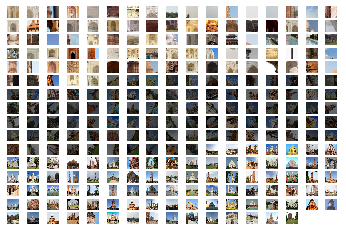

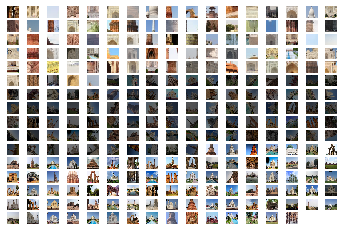

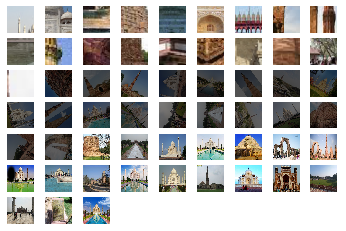

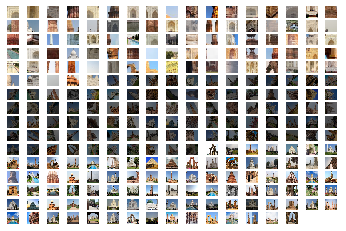

In [23]:
datagen_args1 = dict(horizontal_flip=True,zoom_range=[0.1,0.2])
datagen_args2 = dict(rotation_range=90, brightness_range=[0.3,0.5])
batch_size = 90
image_generator_aug1 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,**datagen_args1)
image_generator_aug2 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,**datagen_args2)
image_generator_normal = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data_aug1 = image_generator_aug1.flow_from_directory(root_path, classes=['Taj_Mahal','Qutb_Minar'], target_size=IMAGE_SHAPE, batch_size=batch_size)
image_data_aug2 = image_generator_aug2.flow_from_directory(root_path, classes=['Taj_Mahal','Qutb_Minar'], target_size=IMAGE_SHAPE, batch_size=batch_size)
image_data_normal = image_generator_normal.flow_from_directory(root_path, classes=['Taj_Mahal','Qutb_Minar'], target_size=IMAGE_SHAPE, batch_size=batch_size)

def concat(*iterables):
    while True:
        data = [i.next() for i in iterables]
        yield np.concatenate([i[0] for i in data], axis=0), np.concatenate([i[1] for i in data], axis=0)

to_merge = [image_data_aug1,image_data_aug2,image_data_normal]
train_data = concat(*to_merge)
num_classes = image_data_aug1.num_classes
batch_size = len(to_merge) * batch_size
print(f">>> merge {len(to_merge)} 个iter后的batch_size为: {batch_size}")
print(">>> 如下显示加了 [旋转、反转] 等augmentation的训练集（合并了多个generator）")
for i in range(199*3//batch_size+1+1):
    pics, label_batch = train_data.__next__()
    if i == 0:
        print(" 独立演示train_data里的第一项")
        print(" Image batch shape: ", pics.shape)
        print(" Label batch shape: ", label_batch.shape)
        print("~~"*15)
    print(pics.shape)
    if i == 199*3//batch_size:
        print(">>> 已经消费完所有数据，后面从头开始从generator里获取数据")
    r = int(len(pics) ** 0.5)
    c = len(pics) // r + 1
    fig,axes_arr = plt.subplots(r,c)
    _ = [ax.set_axis_off() for ax in axes_arr.ravel()]
    for idx, pic in enumerate(pics):
        axes = axes_arr[idx//c, idx % c]
        axes.set_axis_off()
        _ = axes.imshow(pic)

image_batch, label_batch = train_data.__next__()  # 随便拿一个出来当image_batch给后面测试用

## 带有train test/validation 的Generator
基本流程是
- 初始化`ImageDataGenerator`时提供`validation_split`参数
- 然后获取flow时（例如`flow_from_directory`）使用`subset`来标记是取训练集还是测试集

Found 199 images belonging to 2 classes.
Found 199 images belonging to 2 classes.
Found 160 images belonging to 2 classes.
Found 39 images belonging to 2 classes.
>>> merge 3 个iter后的batch_size为: 270
>>> 如下显示加了 [旋转、反转] 等augmentation的训练集（合并了多个generator）
 独立演示train_data里的第一项
 注意后续的shape会比较特别是因为，ig_normal分了20%做验证集，所以会比另外两个没有分validation的提前消耗完
 假设batch_size=90,它在第二次取90个时就消耗完了,只取到了160-90=70个,而另外两个数据集还能取到90个,总计就是70+90*2=250个
 Image batch shape:  (270, 224, 224, 3)
 Label batch shape:  (270, 2)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
(270, 224, 224, 3)
(250, 224, 224, 3)
(128, 224, 224, 3)
>>> 已经消费完所有数据，下一次会从头开始从generator里获取数据
(250, 224, 224, 3)
(270, 224, 224, 3)
>>> 消费完后从头拿到的数据shape是: (108, 224, 224, 3)


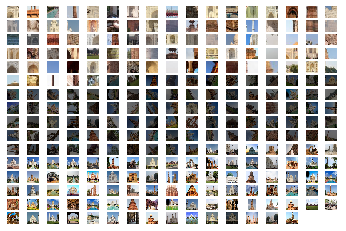

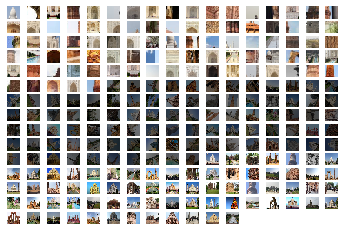

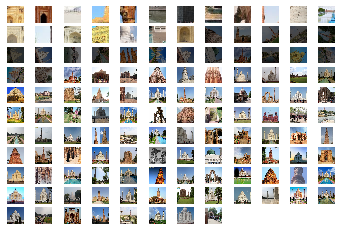

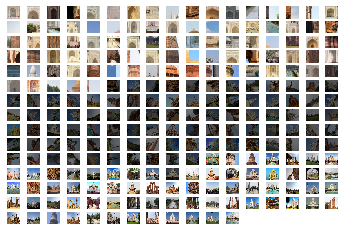

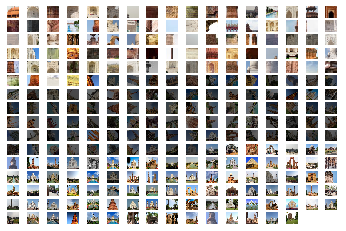

In [6]:
batch_size = 90
validation_ratio=0.2
ig_aug1 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,horizontal_flip=True,zoom_range=[0.1,0.2])
ig_aug2 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,rotation_range=90, brightness_range=[0.3,0.5])
generic_params = dict(directory=root_path, classes=['Taj_Mahal','Qutb_Minar'], target_size=IMAGE_SHAPE, batch_size=batch_size)
augflow1 = ig_aug1.flow_from_directory(**generic_params)
augflow2 = ig_aug2.flow_from_directory(**generic_params)
# 一般用没有augmentation的数据做验证集
generic_params = dict(directory=root_path, classes=['Taj_Mahal','Qutb_Minar'], target_size=IMAGE_SHAPE, batch_size=batch_size)
ig_normal = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=validation_ratio,rescale=1/255)
normal_flow_train = ig_normal.flow_from_directory(subset='training', **generic_params)
normal_flow_valid = ig_normal.flow_from_directory(subset='validation', **generic_params)


def concat(*iterables):
    while True:
        data = [i.next() for i in iterables]
        yield np.concatenate([i[0] for i in data], axis=0), np.concatenate([i[1] for i in data], axis=0)

to_merge = [augflow1,augflow2,normal_flow_train]
train_data = concat(*to_merge)
num_classes = augflow1.num_classes
samples = sum(i.samples for i in to_merge)
batch_size = len(to_merge) * batch_size
print(f">>> merge {len(to_merge)} 个iter后的batch_size为: {batch_size}")
print(">>> 如下显示加了 [旋转、反转] 等augmentation的训练集（合并了多个generator）")
for i in range(samples//batch_size+1+2): # 多循环两轮
    pics, label_batch = train_data.__next__()
    if i == 0:
        print(" 独立演示train_data里的第一项")
        print(" 注意后续的shape会比较特别是因为，ig_normal分了20%做验证集，所以会比另外两个没有分validation的提前消耗完")
        print(" 假设batch_size=90,它在第二次取90个时就消耗完了,只取到了160-90=70个,而另外两个数据集还能取到90个,总计就是70+90*2=250个")
        print(" Image batch shape: ", pics.shape)
        print(" Label batch shape: ", label_batch.shape)
        print("~~"*15)
    print(pics.shape)
    if i == samples//batch_size:
        print(">>> 已经消费完所有数据，下一次会从头开始从generator里获取数据")
    r = int(len(pics) ** 0.5)
    c = len(pics) // r + 1
    fig,axes_arr = plt.subplots(r,c)
    _ = [ax.set_axis_off() for ax in axes_arr.ravel()]
    for idx, pic in enumerate(pics):
        axes = axes_arr[idx//c, idx % c]
        axes.set_axis_off()
        _ = axes.imshow(pic)

image_batch, label_batch = train_data.__next__()  # 随便拿一个出来当image_batch给后面测试用
print(f">>> 消费完后从头拿到的数据shape是: {image_batch.shape}")

加载classification model预测分类

In [7]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}
clf = tf.keras.Sequential([hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


加载headless model预测feature_vector

In [8]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}
feat_layer = hub.KerasLayer(feature_extractor_url, input_shape=(224,224,3))

注意:
- clf是 `tf.keras.Sequential` 搭起来的
- feat_layer是`hub.KerasLayer`直接做的一个`Layer`，所以得到的结果是一个`Tensor`

In [9]:
image_batch.shape

(108, 224, 224, 3)

In [10]:
image_batch_part = image_batch[:16]
pred_res = clf.predict(image_batch_part)
print(f"clf的结果,shape: {pred_res.shape}, argmax: {np.argmax(pred_res, axis=1)}\n",pred_res)
feat_layer(image_batch_part)

clf的结果,shape: (16, 1001), argmax: [799 811 790 813 730 494 709 764 886 855 676 687 784 799 742 410]
 [[ 0.41984347 -1.1089791   0.1370507  ... -0.44971058 -1.0999801
   0.5943046 ]
 [ 0.4700432  -2.0031974   1.7438186  ...  1.1122321  -1.7425269
  -0.02220334]
 [ 0.53007865  0.16206266 -0.45019853 ...  0.8179613  -2.5515778
  -1.9000454 ]
 ...
 [ 0.45008472 -0.62004256  0.5045703  ... -1.5334214  -1.8259358
  -0.0653726 ]
 [ 0.41485736 -2.632419    1.2682639  ...  0.11788546 -1.1342554
   1.197948  ]
 [ 0.23933211 -0.16966875  0.27514088 ... -0.9144943  -0.794981
  -1.2860968 ]]


<tf.Tensor 'keras_layer_1/cond/Merge:0' shape=(16, 1280) dtype=float32>

## Model

In [13]:
feat_layer.trainable = False  # feature_vector的生成就不用训练了
model = tf.keras.Sequential([
  feat_layer,
  tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.summary()
pred = model(image_batch)
pred
model.compile(optimizer=tf.keras.optimizers.Adam(), loss="categorical_crossentropy", metrics=['acc'])

NameError: name 'feat_layer' is not defined

## CallBack

In [13]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

上面用`concat`方式的结果，要注意`validation_step`
- 如果用`normal_flow_valid.samples // batch_size`注意是否为0

## Fit

In [18]:
steps_per_epoch = np.ceil(samples//batch_size)
batch_stats_callback = CollectBatchStats()
history = model.fit_generator(normal_flow_train, epochs=4,
                              steps_per_epoch = normal_flow_train.samples//40,
                              validation_data = normal_flow_valid,
                              validation_steps = normal_flow_valid.samples ,
                              callbacks = [batch_stats_callback])

Epoch 1/4
4/4 [==============================] - 22s 5s/step - loss: 0.3010 - acc: 0.9111 - val_loss: 0.3753 - val_acc: 0.8718
Epoch 2/4
4/4 [==============================] - 21s 5s/step - loss: 0.2653 - acc: 0.9667 - val_loss: 0.3328 - val_acc: 0.9487
Epoch 3/4
4/4 [==============================] - 21s 5s/step - loss: 0.2260 - acc: 0.9857 - val_loss: 0.2855 - val_acc: 0.9744
Epoch 4/4
4/4 [==============================] - 21s 5s/step - loss: 0.2014 - acc: 0.9889 - val_loss: 0.2574 - val_acc: 0.9744


In [ ]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

img_width, img_height = 256, 256
train_data_dir = "tf_files/codoon_photos"
validation_data_dir = "tf_files/codoon_photos"
nb_train_samples = 4125
nb_validation_samples = 466 
batch_size = 16
epochs = 50

model = applications.ResNet50(include_top=False, weights='imagenet', input_shape=(img_width, img_height, 3))

# Freeze the layers which you don't want to train. Here I am freezing the all layers.
for layer in model.layers[:]:
    layer.trainable = False

# Adding custom Layer
# We only add
x = model.output
x = Flatten()(x)
# Adding even more custom layers
# x = Dense(1024, activation="relu")(x)
# x = Dropout(0.5)(x)
# x = Dense(1024, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

# creating the final model 
model_final = Model(input = model.input, output = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

# Initiate the train and test generators with data Augumentation 
train_datagen = ImageDataGenerator(
  rescale = 1./255,
  horizontal_flip = True,
  fill_mode = "nearest",
  zoom_range = 0.3,
  width_shift_range = 0.3,
  height_shift_range=0.3,
  rotation_range=30)

test_datagen = ImageDataGenerator(
  rescale = 1./255,
  horizontal_flip = True,
  fill_mode = "nearest",
  zoom_range = 0.3,
  width_shift_range = 0.3,
  height_shift_range=0.3,
  rotation_range=30)

train_generator = train_datagen.flow_from_directory(
  train_data_dir,
  target_size = (img_height, img_width),
  batch_size = batch_size,
  class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(
  validation_data_dir,
  target_size = (img_height, img_width),
  class_mode = "categorical")

# Save the model according to the conditions  
checkpoint = ModelCheckpoint("resnet50_retrain.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')


# Train the model 
model_final.fit_generator(
  train_generator,
  samples_per_epoch = nb_train_samples,
  epochs = epochs,
  validation_data = validation_generator,
  nb_val_samples = nb_validation_samples,
  callbacks = [checkpoint, early])


# 机器打分

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib

In [62]:
?df.dropna

In [64]:
df = pd.read_csv("/home/zhoutong/res.csv")
df['id'] = df['id'].astype(int)
df.count()
print("去掉na")
df = df.dropna()
df.count()
df.head(3)

id            11816
showCnt       11816
clickCnt      11816
ctr           11816
dt            11816
banner_url    11815
rn            11816
dtype: int64

id            11815
showCnt       11815
clickCnt      11815
ctr           11815
dt            11815
banner_url    11815
rn            11815
dtype: int64

,id,showCnt,clickCnt,ctr,dt,banner_url,rn
0,1569655800492983,445,2182,4.903371,2019-10-06,https://thumbor.apusapps.com/imageView2/materi...,1
1,1567597201833855,448,611,1.363839,2019-10-06,https://thumbor.apusapps.com/imageView2/materi...,1
2,1570647900239814,337,367,1.089021,2019-10-13,https://thumbor.apusapps.com/imageView2/materi...,1


各百分位对应的ctr:


[(5, 0.008174386920980926),
 (15, 0.015555962343096235),
 (25, 0.02226262479410934),
 (50, 0.0404657514554733),
 (75, 0.06802146312329209),
 (95, 0.1330124012348909)]

取上四分位为正样本，下四分位为负样本
正样本计数: 20692, 负样本计数: 20370


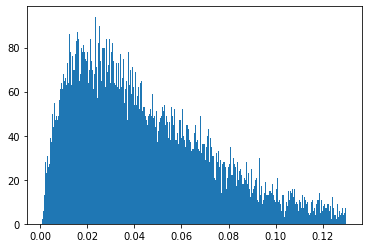

去掉极端值后分布如上，中位数: 0.038348082595870206
均值: 0.044438630713987605


In [68]:
ctr = df['ctr'].to_numpy()
print("各百分位对应的ctr:")
[(i,np.percentile(ctr,i)) for i in [5,15,25,50,75,95]]
print("取上四分位为正样本，下四分位为负样本")
neg,pos = df.query("ctr<0.022"),df.query("ctr>0.068")
print(f"正样本计数: {pos.size}, 负样本计数: {neg.size}")
_ = plt.hist(ctr[np.logical_and(ctr<0.13, ctr>0)],bins=300)
plt.show()
print("去掉极端值后分布如上，中位数:",np.percentile(ctr[np.logical_and(ctr<0.13, ctr>0)], 50))
print("均值:",np.mean(ctr[np.logical_and(ctr<0.13, ctr>0)]))


In [73]:
neg['banner_url'].size

2910

In [72]:
np.unique(neg['banner_url']).size

2909

In [77]:
sample_dir="./tmp/auto_score"
print("下载图片至本地: ",sample_dir)

def download_pos(url):
    path = sample_dir+"/pos/"+url.split("/")[-1].split("?")[0]
    urllib.request.urlretrieve(url,path)
    
def download_neg(url):
    path = sample_dir+"/neg/"+url.split("/")[-1].split("?")[0]
    urllib.request.urlretrieve(url,path)
    
from multiprocessing import Pool
p = Pool(4)
iter_to_run = p.imap(download_neg, neg['banner_url'])
_ = list(tqdm(iter_to_run,total=neg['banner_url'].size,desc="download neg:"))

iter_to_run = p.imap(download_pos, pos['banner_url'])
_ = list(tqdm(iter_to_run,total=pos['banner_url'].size,desc="download pos:"))

下载图片至本地:  ./tmp/auto_score


Process ForkPoolWorker-16:
Process ForkPoolWorker-18:
Process ForkPoolWorker-17:
Process ForkPoolWorker-15:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/zhoutong/python3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/zhoutong/python3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/zhoutong/python3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/zhoutong/python3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/zhoutong/python3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zhoutong/python3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zhoutong/pytho

In [78]:
IMAGE_SHAPE = (224,224)
batch_size = 1
validation_ratio=0.3
sample_dir="./tmp/auto_score"
generic_params = dict(directory=sample_dir, classes=['pos','neg'], target_size=IMAGE_SHAPE, batch_size=batch_size)
ig_normal = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=validation_ratio,rescale=1/255)
normal_flow_train = ig_normal.flow_from_directory(subset='training', **generic_params)
normal_flow_valid = ig_normal.flow_from_directory(subset='validation', **generic_params)

for image_batch, label_batch in normal_flow_train:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

# 重新加载一下iter
normal_flow_train = ig_normal.flow_from_directory(subset='training', **generic_params)

Found 3684 images belonging to 2 classes.
Found 1577 images belonging to 2 classes.
Image batch shape:  (1, 224, 224, 3)
Label batch shape:  (1, 2)
Found 3684 images belonging to 2 classes.


In [83]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/4" #@param {type:"string"}
feat_layer = hub.KerasLayer(feature_extractor_url, input_shape=(224,224,3))
feat_layer.trainable = False  # feature_vector的生成就不用训练了
model = tf.keras.Sequential([
  feat_layer,
  tf.keras.layers.Dense(normal_flow_train.num_classes, activation='softmax')
])
model.summary()
pred = model(image_batch)
pred
model.compile(optimizer=tf.keras.optimizers.Adam(), loss="categorical_crossentropy", metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1536)              54336736  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 3074      
Total params: 54,339,810
Trainable params: 3,074
Non-trainable params: 54,336,736
_________________________________________________________________


<tf.Tensor 'sequential_1/dense_1/Softmax:0' shape=(1, 2) dtype=float32>

In [84]:
class HistoryCB(tf.keras.callbacks.History):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()



In [12]:
history = model.fit_generator(normal_flow_train, epochs=4,
                              steps_per_epoch = normal_flow_train.samples//40,
                              validation_data = normal_flow_valid,
                              validation_steps = normal_flow_valid.samples)

NameError: name 'model' is not defined

In [90]:
dir(history)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_chief_worker_only',
 '_keras_api_names',
 '_keras_api_names_v1',
 'epoch',
 'history',
 'model',
 'on_batch_begin',
 'on_batch_end',
 'on_epoch_begin',
 'on_epoch_end',
 'on_predict_batch_begin',
 'on_predict_batch_end',
 'on_predict_begin',
 'on_predict_end',
 'on_test_batch_begin',
 'on_test_batch_end',
 'on_test_begin',
 'on_test_end',
 'on_train_batch_begin',
 'on_train_batch_end',
 'on_train_begin',
 'on_train_end',
 'params',
 'set_model',
 'set_params',
 'validation_data']

In [97]:
history.params
history.history

{'batch_size': None,
 'epochs': 4,
 'steps': 92,
 'samples': 92,
 'verbose': 1,
 'do_validation': True,
 'metrics': ['loss', 'acc', 'val_loss', 'val_acc']}

{'loss': [1.5400986496521079,
  1.3300625532865524,
  1.3946281146744024,
  1.3666832427615705],
 'acc': [1.0, 1.0, 0.0, 0.0],
 'val_loss': [1.4355720153849716,
  31.220346292477284,
  491.9740676795975,
  4145.35255869658],
 'val_acc': [0.46290424, 0.48826885, 0.5206087, 0.5339252]}

## 模型保存

In [ ]:
# 使用 `checkpoint_path` 格式保存权重
# checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
# model.save_weights(checkpoint_path.format(epoch=0))
# model.save("mymodel.h5")

In [98]:
model.save("./tmp/auto_score/models/model_bysave.h5")

In [88]:
tf.keras.models.save_model(
    model=model,
    filepath="./tmp/auto_score/models/model_1",
    overwrite=True,
    include_optimizer=True,
    save_format="h5",
    signatures=None,
)

## 模型加载

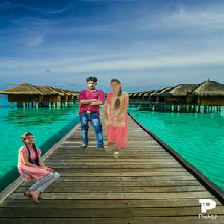

In [7]:
pos_path="/home/zhoutong/notebook_collection/tmp/auto_score/pos/{}"
neg_path="/home/zhoutong/notebook_collection/tmp/auto_score/neg/{}"

img = Image.open(pos_path.format("2060713010_1570648202589.jpg")).resize((224,224))
img

In [9]:
bysave = tf.keras.models.load_model("./tmp/auto_score/models/model_bysave.h5", custom_objects={'KerasLayer':hub.KerasLayer})
bysave.build((None,224,224,3))
type(bysave)
print(">>> test: ")
type(bysave)
bysave.predict(np.expand_dims(np.array(img),0))

tensorflow.python.keras.engine.sequential.Sequential

>>> test: 


tensorflow.python.keras.engine.sequential.Sequential

array([[1., 0.]], dtype=float32)

In [10]:
bytfkeras = tf.keras.models.load_model("./tmp/auto_score/models/model_1", custom_objects={'KerasLayer':hub.KerasLayer})
bytfkeras.build((None,224,224,3))
print(">>> test: ")
type(bytfkeras)
bytfkeras.predict(np.expand_dims(np.array(img),0))

>>> test: 


tensorflow.python.keras.engine.sequential.Sequential

array([[1., 0.]], dtype=float32)